![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FDev&dt=BQML+Feature+Engineering.ipynb)
# BigQuery ML (BQML) - Advanced Feature Engineering


---
## Colab Setup


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/BQML%20Feature%20Engineering.ipynb)

In [1]:
try:
    import google.colab
    !pip install --upgrade witwidget -q
    !pip install --upgrade google-cloud-aiplatform -q
    !pip install --upgrade google-cloud-bigquery -q
    !pip install --upgrade google-cloud-bigquery-storage -q
    from google.colab import auth
    auth.authenticate_user()
except Exception:
    pass

In [2]:
PROJECT_ID = 'statmike-mlops-349915'
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



---
## Setup

inputs:

In [47]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [48]:
REGION = 'us-central1'
EXPERIMENT = 'feature_engineering'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'feature_engineering'
BQ_TABLE = 'fraud'
BQ_SOURCE = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'

packages:

In [49]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import json

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

clients:

In [50]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project=PROJECT_ID)
gcs = storage.Client(project = PROJECT_ID)

parameters:

In [51]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"

environment:

In [52]:
DIR = f"temp/{EXPERIMENT}"
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create BigQuery Dataset

In [62]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
explained_columns
feature_engineering
forecasting_8_tournament
fraud
model_deployment_monitoring_1961322035766362112


Create the dataset if missing:

In [63]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = 'eu' #'us' #REGION
ds.labels = {'experiment': f'{EXPERIMENT}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

List BigQuery datasets in the project:

In [64]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
explained_columns
feature_engineering
forecasting_8_tournament
fraud
model_deployment_monitoring_1961322035766362112


---
## BigQuery Table
The source data is in the `US` multi-region and the work is in the `EU` multi-region.  This section copys the table from it's origin to destination by first exporting the a GCS bucket and then importing in the BigQuery.

---
### Create Storage Bucket
Check to see if bucket already exist and create if missing:
- [GCS Python Client](https://cloud.google.com/python/docs/reference/storage/latest/google.cloud.storage.client.Client)

In [54]:
if not gcs.lookup_bucket(BUCKET+'_eu'):
    bucketDef = gcs.bucket(BUCKET+'_eu')
    bucket = gcs.create_bucket(bucketDef, project=PROJECT_ID, location='eu') # location = REGION
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs.bucket(BUCKET+'_eu')
    print(f'Bucket already exist: {bucketDef.name}')

Created Bucket: statmike-mlops-349915


In [59]:
print(f'Review the storage bucket in the console here:\nhttps://console.cloud.google.com/storage/browser/{PROJECT_ID}_eu;tab=objects&project={PROJECT_ID}')

Review the storage bucket in the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915_eu;tab=objects&project=statmike-mlops-349915


---
### Store the Source Data in GCS Storage Bucket
Check to see if the export exist and create if not:
- export from bigquery table to GCS bucket as CSV
    - the table is referenced in the `BQ_SOURCE` variable at the top of this notebook
- [Exporting Table Data](https://cloud.google.com/bigquery/docs/exporting-data#python)
- [BigQuery Python Client](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_extract_table)

For more tips on interacting with GCS using the Python Client review the tips notebook [Python Client for GCS](../Tips/Python%20Client%20for%20GCS.ipynb).

In [56]:
file = f"{SERIES}/{EXPERIMENT}/data/{BQ_TABLE}.csv"

In [57]:
bucketDef = gcs.bucket(BUCKET+'_eu')
if storage.Blob(bucket = bucketDef, name = file).exists(gcs):
    print(f'The file has already been created at: gs://{bucketDef.name}/{file}')
else:
    source = bigquery.TableReference.from_string(BQ_SOURCE)
    extract = bq.extract_table(source = source, location = 'us', destination_uris = [f'gs://{bucketDef.name}/{file}'])
    print('Creating the export ...')
    extract.result()
    print(f'Exported the table to: gs://{bucketDef.name}/{file}')

Creating the export ...
Exported the table to: gs://statmike-mlops-349915_eu/03/feature_engineering/data/fraud.csv


list files in the bucket:

In [58]:
list(bucketDef.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}'))

[<Blob: statmike-mlops-349915_eu, 03/feature_engineering/data/fraud.csv, 1668167410577114>]

In [61]:
print(f'Review the files in the console here:\nhttps://console.cloud.google.com/storage/browser/{PROJECT_ID}_eu/{SERIES};tab=objects&project={PROJECT_ID}')

Review the files in the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915_eu/03;tab=objects&project=statmike-mlops-349915


---
### Create BigQuery Table

In [65]:
from google.cloud.exceptions import NotFound
try:
    table = bq.get_table(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
    if table:
        print(f'The table already exists: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
except NotFound as error:
    print(f'Creating Table ...')
    destination = bigquery.TableReference.from_string(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")
    job_config = bigquery.LoadJobConfig(
        write_disposition = 'WRITE_TRUNCATE',
        source_format = bigquery.SourceFormat.CSV,
        autodetect = True,
        labels = {'experiment': f'{EXPERIMENT}'}
    )
    job = bq.load_table_from_uri(f"gs://{bucketDef.name}/{file}", destination, job_config = job_config)
    job.result()
    print(f'Finished creating table: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')

Creating Table ...
Finished creating table: statmike-mlops-349915.feature_engineering.fraud


### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

In [66]:
print(f"Direct Link To This Project In BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}")

Direct Link To This Project In BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


---
## Review Data in BigQuery
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

> **Note:** <p>This query only selects one column.  This means BigQuery scans less data as it does not process the other columns.  </p>

In [67]:
query = f"""
SELECT {VAR_TARGET}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [68]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: Int64

In [69]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: Float64

---
## Train Model - Automatic Feature Engineering

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)

In [73]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'model_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}', 'auto_feature_engineering']
    ) AS
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query = query)
job.result()

In [74]:
(job.ended-job.started).total_seconds()

205.8

In [75]:
job.total_bytes_processed

70632136

Add labels to the model in BigQuery:

In [76]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [77]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94819.368821,85378.000000,47471.724979,<NA>,0,<NA>
1,V1,-46.855047,2.454930,0.000906,-0.053293,1.953269,<NA>,0,<NA>
2,V2,-63.344698,22.057729,0.000080,0.061331,1.643143,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.000548,0.181596,1.514012,<NA>,0,<NA>
4,V4,-5.683171,16.875344,-0.000894,0.003125,1.414922,<NA>,0,<NA>
5,V5,-113.743307,34.099309,0.000092,-0.054059,1.378868,<NA>,0,<NA>
6,V6,-23.496714,73.301626,0.000223,-0.301455,1.331745,<NA>,0,<NA>
7,V7,-43.557242,120.589494,0.000765,0.033103,1.236094,<NA>,0,<NA>
8,V8,-73.216718,20.007208,-0.000559,0.021796,1.195511,<NA>,0,<NA>
9,V9,-13.320155,15.594995,-0.000346,-0.038416,1.098277,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [78]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.683058,0.686816,0.2,12587
1,0,1,0.644951,0.649081,0.4,14131
2,0,2,0.577088,0.581807,0.8,12566
3,0,3,0.469349,0.474834,1.6,13997
4,0,4,0.332700,0.338950,3.2,13813
5,0,5,0.214496,0.221454,6.4,14063
6,0,6,0.155707,0.163524,12.8,11908
7,0,7,0.115863,0.123349,25.6,13313


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

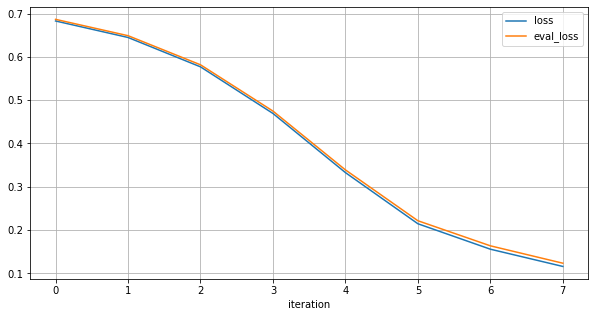

In [79]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [80]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [81]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3s03_feature_engineering_20221111114522


---
## Train Model - Advanced Feature Engineering

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)

Feature Pre-Processing with the `TRANSFORM` statement:
- [TRANSFORM](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform)

In [83]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
TRANSFORM (* EXCEPT(V1, V2),#, V3),
    ML.MAX_ABS_SCALER(V1) OVER() as V1,
    ML.ROBUST_SCALER(V2) OVER() as V2,
    #ML.NORMALIZER(V3) OVER() as V3
)
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'model_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}', 'advanced_feature_engineering']
    ) AS
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query = query)
job.result()

BadRequest: 400 Already Exists: Model statmike-mlops-349915.feature_engineering.03_feature_engineering_20221111114522

Location: EU
Job ID: 3730d9d7-4160-4466-abd9-0a5f055a23da


In [30]:
(job.ended-job.started).total_seconds()

170.744

In [39]:
job.total_bytes_processed

70632136

Add labels to the model in BigQuery:

In [31]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_AFE')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [32]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_AFE`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94819.368821,86044.000000,47471.724979,<NA>,0,<NA>
1,V1,-46.855047,2.454930,0.000906,-0.041542,1.953269,<NA>,0,<NA>
2,V2,-63.344698,22.057729,0.000080,0.048752,1.643143,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.000548,0.193006,1.514012,<NA>,0,<NA>
4,V4,-5.683171,16.875344,-0.000894,0.002292,1.414922,<NA>,0,<NA>
5,V5,-113.743307,34.099309,0.000092,-0.050779,1.378868,<NA>,0,<NA>
6,V6,-23.496714,73.301626,0.000223,-0.306716,1.331745,<NA>,0,<NA>
7,V7,-43.557242,120.589494,0.000765,0.033950,1.236094,<NA>,0,<NA>
8,V8,-73.216718,20.007208,-0.000559,0.020415,1.195511,<NA>,0,<NA>
9,V9,-13.320155,15.594995,-0.000346,-0.049993,1.098277,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [33]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_AFE`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.683058,0.686816,0.2,10975
1,0,1,0.644951,0.649081,0.4,9718
2,0,2,0.577088,0.581807,0.8,9832
3,0,3,0.469349,0.474834,1.6,11112
4,0,4,0.332700,0.338950,3.2,10998
5,0,5,0.214496,0.221454,6.4,10561
6,0,6,0.155707,0.163524,12.8,12274
7,0,7,0.115863,0.123349,25.6,12597


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

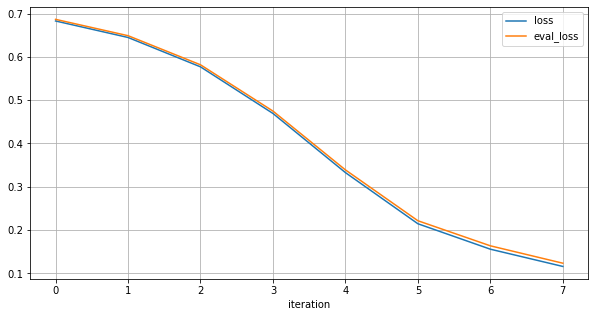

In [34]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [35]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [36]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}_AFE')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3s03_fe_20221109002538


---
## Serving

### Vertex AI Model Registry - Get Model

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [44]:
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}')

In [45]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_03_fe@1'

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [46]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720/operations/3825061658653360128
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/6193790891820318720')
Endpoint Created: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/6193790891820318720?project=statmike-mlops-349915


In [47]:
endpoint.display_name

'03'

In [48]:
endpoint.traffic_split

{}

In [49]:
deployed_models = endpoint.list_models()
#deployed_models

### Deploy Model To Vertex AI Endpoint

In [52]:
if (model.display_name, model.version_id) not in [(deployed_model.display_name, deployed_model.model_version_id) for deployed_model in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: 
    print(f'The current model/version is already deployed.')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_03_fe to Endpoint : projects/1026793852137/locations/us-central1/endpoints/6193790891820318720
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720/operations/6761408615698923520
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720


### Remove Deployed Models without Traffic

In [53]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model model_03_fe with version 1 has traffic = 100


In [54]:
endpoint.traffic_split

{'6895982997783183360': 100}

In [55]:
#endpoint.list_models()

---
## Prediction

### Retrieve Records For Prediction

In [58]:
n = 10
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} LIMIT {n}").to_dataframe()

In [59]:
pred.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,37294.0,1.168909,-0.139981,-0.095518,1.735426,1.699903,4.646212,-1.191502,1.205700,0.333882,...,-0.033003,0.114218,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0
1,48695.0,-0.945317,2.018842,1.779540,2.340482,0.624353,0.059572,1.167144,-0.374930,-0.810309,...,-0.703688,-1.473276,-0.107746,-0.234128,0.061720,-0.197649,0.299470,-0.117605,0.0,0
2,66175.0,1.068135,0.153241,1.620380,2.652865,-0.918265,0.331406,-0.712275,0.345064,-0.035753,...,-0.031012,-0.012003,0.068278,0.501400,0.211693,-0.070294,0.033991,0.025698,0.0,0
3,87939.0,2.152846,0.138200,-2.556943,0.410630,0.876571,-1.333338,0.859437,-0.476419,0.057148,...,0.244421,0.806456,-0.126303,0.734384,0.645127,0.700713,-0.134631,-0.090770,0.0,0
4,131288.0,1.967256,0.727108,-1.087221,3.851212,0.675885,-0.576084,0.636685,-0.299253,-1.143070,...,-0.023855,0.043501,0.102387,0.026050,0.222577,0.018297,-0.060855,-0.061035,0.0,0


Shape as instances: dictionaries of key:value pairs for only features used in model

In [61]:
newobs = pred[pred.columns[~pred.columns.isin([VAR_TARGET])]].to_dict(orient='records')
#newobs[0]

In [62]:
len(newobs)

10

In [63]:
newobs[0]

{'Time': 37294.0,
 'V1': 1.1689085895338,
 'V2': -0.139981145657757,
 'V3': -0.095518471489871,
 'V4': 1.7354261527226698,
 'V5': 1.6999032220861598,
 'V6': 4.64621174854514,
 'V7': -1.1915020802253,
 'V8': 1.2056999126741101,
 'V9': 0.333882136042143,
 'V10': 0.445892376640398,
 'V11': -1.13915797098511,
 'V12': 0.131478997864883,
 'V13': -0.21300435713576701,
 'V14': -0.574543656752157,
 'V15': -1.29448382329134,
 'V16': 0.35821793406784797,
 'V17': -0.493553806335129,
 'V18': 0.14011509156796803,
 'V19': -0.19333259123795105,
 'V20': -0.0671614045807908,
 'V21': -0.0330034889037295,
 'V22': 0.11421779751978099,
 'V23': -0.163862790897918,
 'V24': 1.04559307565716,
 'V25': 0.7753427063516221,
 'V26': 0.22874539817184697,
 'V27': 0.0508464765501748,
 'V28': 0.0200185496706404,
 'Amount': 0.0}

In [64]:
instances = [json_format.ParseDict(newobs[0], Value())]

### Get Predictions: Python Client

In [74]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[{'Class_values': ['1', '0'], 'predicted_Class': ['0'], 'Class_probs': [0.09128659808702194, 0.9087134019129781]}], deployed_model_id='6895982997783183360', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/model_03_fe', explanations=None)

In [78]:
prediction.predictions[0]

{'Class_values': ['1', '0'],
 'predicted_Class': ['0'],
 'Class_probs': [0.09128659808702194, 0.9087134019129781]}

In [79]:
prediction.predictions[0]['Class_probs']

[0.09128659808702194, 0.9087134019129781]

In [81]:
prediction.predictions[0]['Class_values'][np.argmax(prediction.predictions[0]['Class_probs'])]

'0'

### Get Predictions: REST

In [87]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [88]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "Class_probs": [
        0.091286598087021942,
        0.90871340191297811
      ],
      "Class_values": [
        "1",
        "0"
      ],
      "predicted_Class": [
        "0"
      ]
    }
  ],
  "deployedModelId": "6895982997783183360",
  "model": "projects/1026793852137/locations/us-central1/models/model_03_fe",
  "modelDisplayName": "model_03_fe",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [89]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'Class_probs': [0.09128659808702194, 0.9087134019129781], 'Class_values': ['1', '0'], 'predicted_Class': ['0']}]


---
## Remove Resources
- eu bucket
- endpoints
- bq_dataset


In [86]:
bucketDef.delete(force = True)

In [90]:
# delete endpoints here

In [89]:
bq.delete_dataset(ds.dataset_id, delete_contents = True, not_found_ok = True)